--- Creating the list of stopwords to clean

In [19]:
from nltk.corpus import stopwords
import string

smiles_negativ = [':(', ':-(', '=(', ')-:', '):', ');', ')=']
smiles_positiv = [':)', ':-)', '=)', ':D', ';-)', ';)', '(-;', '(-:', '(:', '(;', '(=', ':d', ':p']
smiles = smiles_negativ + smiles_positiv

punctuation = list(string.punctuation)

special_stopwords = ['rt', 'les', 'au', 'aux', 'de', 'des', 'du', 'e', 'ee', 'cette', '’', 'leurs', "'", '…',
                    'la', 'le', 'les', 'un', 'une', 'en', 'y', 'et', 'ce', 'ces', 'cette', 'à', '...' ]

stop_words =  smiles + special_stopwords + punctuation

--- Function to create tokens

In [20]:
import nltk
import re
from nltk.stem.snowball import FrenchStemmer

def preprocess(string, bigrams=False, replace_accents=True, stop_words=stop_words, stemming=True, 
                negation_bigram=True, superlative_bigram=False):
    
    ### lower case
    string = string.lower()
    
    ### remove HTML tags, @-mentions, # hash-tags, # URLs, # numbers 
    twit = [
        r'<[^>]+>', # HTML tags
        r'(?:@[\w_]+)', # @-mentions
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
        r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
        ]
    re_twit = re.compile(r'('+'|'.join(twit)+')', re.VERBOSE | re.IGNORECASE)
    string = re.sub(re_twit, "", string)
    
    ### replace accents
    if replace_accents:
        re_e = re.compile(r'[èêé]')
        re_a = re.compile(r'à')
        re_c = re.compile(r'ç')
        re_u = re.compile(r'ù')
        
        string = re.sub(re_e, 'e',string)
        string = re.sub(re_a, 'a',string)
        string = re.sub(re_c, 'c',string)
        string = re.sub(re_u, 'u',string)
    
    ### simple tokenizing
    tokens = nltk.word_tokenize(string)
     
    ### cleaning from stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    ### Stemming
    if stemming:
        tokens = stem_tokens(tokens)
    
    ### ['tres'] + word, word + ['tres'] form a bigram
    if superlative_bigram:
        tokens_copy = tokens.copy()
        index = 0
        for token in tokens_copy:
            if token == 'tres':
                if index != len(tokens)-1:
                    token_new = str(token) + ' ' + str(tokens[index+1])
                    tokens[index+1] = token_new
            index += 1
        tokens = [token for token in tokens if token != 'tres']
        
    
    ### pas + word, word + pas form a bigram
    if negation_bigram:
        tokens_copy = tokens.copy()
        index = 0
        for token in tokens_copy:
            if token == 'pas':
                if index != 0:
                    token_new1 = str(tokens[index-1]) + ' ' + str(token)
                    tokens[index-1] = token_new1 
                if index != len(tokens)-1:
                    token_new2 = str(token) + ' ' + str(tokens[index+1])
                    tokens[index+1] = token_new2
            index += 1
        tokens = [token for token in tokens if token != 'pas']
    
    ### Bigrams
    if bigrams:
        tokens = nltk.bigrams(tokens)

    return tokens 


def stem_tokens(tokens):
    stemmer = FrenchStemmer()
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

--- Testing preprocessing function (optinal)

In [21]:
tweet = "Il neige @neige encore ce matin. :) C'est pas très beau ! ça passe... On va avoir une belle hivers on dirait !!! #hivers"
list(preprocess(tweet))

['il',
 'neig',
 'encor',
 'matin',
 "c'est pas",
 'pas tre',
 'beau',
 'ca',
 'pass',
 'on',
 'va',
 'avoir',
 'bel',
 'hiver',
 'on',
 'dir']

--- Reading the positive twitts

In [22]:
import json
import numpy as np
import operator
from nltk import bigrams
from collections import Counter

tweets_text_pos = []
count_all_pos = Counter()
tweets_text = []
count_all = Counter()

for line in open('pos_selected.json'):
    try:
        text = json.loads(line)
        tweets_text_pos.append(text)
        tweets_text.append(text)
        
        tokens = list(preprocess(text))
        count_all_pos.update(tokens)
        count_all.update(tokens)

    except:
        pass
    
mood_pos = np.ones(len(tweets_text_pos))

--- Reading negative twitts

In [23]:
import json
import numpy as np
import operator
from nltk import bigrams
from collections import Counter

tweets_text_neg = []
count_all_neg = Counter()

for line in open('neg_selected.json'):
    try: 
        text = json.loads(line)
        tweets_text_neg.append(text)
        tweets_text.append(text)
        
        tokens = list(preprocess(text))
        count_all_neg.update(tokens)
        count_all.update(tokens)

    except:
        pass

mood_neg = np.zeros(len(tweets_text_neg))
mood = list(mood_pos)+list(mood_neg)

In [24]:
len(tweets_text_neg)

5889

In [25]:
len(tweets_text_pos)

3872

--- Entropy calculation

In [26]:
import numpy as np

entropy = {}
plot_build = True

### coefficient to balance the difference in quantaties of positive and negative twitts
alpha = len(count_all_neg)/len(count_all_pos)

for word in list(count_all):
    denominator = count_all_neg[word] + count_all_pos[word]*alpha
    p = count_all_neg[word]/denominator
    if p==0 or p==1:
        entropy[word] = 0
    else:
        entropy[word] = -(p*np.log(p)+(1-p)*np.log(1-p))

--- Let's see the words with the highest entropy (optional)

In [27]:
sorted_entropy = reversed(sorted(entropy.items(), key=operator.itemgetter(1)))
list(sorted_entropy)[0:10]

[('parl', 0.69314711253905281),
 ('dessus', 0.69314265845228995),
 ('entre', 0.69314265845228995),
 ('go', 0.69312201886964242),
 ('noir', 0.69312201886964242),
 ('jeun', 0.69312201886964242),
 ('film', 0.69312201886964242),
 ('pas je', 0.69312201886964242),
 ('non pas', 0.69312201886964242),
 ('attendr', 0.69312201886964242)]

--- Histogram of the entropy (optional)

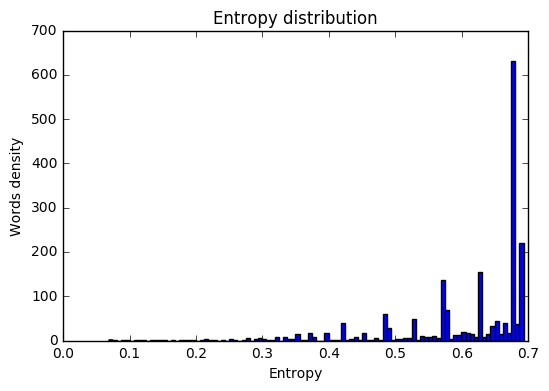

In [28]:
import matplotlib.pyplot as plt
val_arr = []
for val in entropy.values():
    if val>0:
        val_arr.append(val)
plt.clf()
plt.hist(val_arr, bins = 100)
plt.title("Entropy distribution")
plt.xlabel("Entropy")
plt.ylabel("Words density")
plt.gcf()

--- Tf-Idf matrix

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = preprocess
stopwords_exclude = True

big_entropy = True
less_frequent = True

if stopwords_exclude:
    
    stops_count = count_all.copy()
    
    if big_entropy and ~less_frequent:
        for word in list(count_all):
            if entropy[word]<0.5:
                del stops_count[word]
    
    if ~big_entropy and less_frequent:
        for word in list(count_all):
            if count_all[word]>3:
                del stops_count[word]
    
    if big_entropy and less_frequent:
        for word in list(count_all):
            if entropy[word]<0.7 and count_all[word]>4:
                del stops_count[word]
                
    stops = stops_count.keys()
    tfidf = TfidfVectorizer(tokenizer=tokenizer, stop_words = stops)
else:
    tfidf = TfidfVectorizer(tokenizer=tokenizer)

A = tfidf.fit_transform(tweets_text)
feature_names = tfidf.get_feature_names()

--- X --> features, Y --> labels: splitting into train and test parts

In [30]:
A = A.toarray()
X = A
Y = mood
X.shape

(9761, 7710)

In [31]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

--- Learner application: testing different learners (Random Forest, Naive Bayes, SVM)

In [38]:
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.naive_bayes import MultinomialNB as bs
from sklearn.svm import LinearSVC as svm

model = svm()

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

--- Accuracy metrics

In [39]:
def accuracy(real, pred):
    return 1-np.sum(np.abs(real - pred))/len(real)

In [40]:
accuracy(Y_test, Y_pred)

0.81605899221630485